Attention Layer with Contrastive Learning

In [278]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np
import pandas

import scipy
import seaborn as sns

from time import time,sleep
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

from torch import optim

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

mypal = sns.color_palette('Set2')
emp_color = mypal[0]
pred_color = mypal[1]
print ("PyTorch version: " + torch.__version__)


PyTorch version: 1.8.0


In [279]:
from data.utils import SimpleDataset, SimpleDataset_masked

from utils.metrics import NLL_reg, NLL_reg_emb, point_loss, get_CI_raw, pair_Ctd_DLN
from utils.trainer_helpers import batch_t_categorize, time_embedding, wt_avg, attention_mask, get_median


In [357]:
import argparse

parser = argparse.ArgumentParser(description='PyTorch ESSA Training')
parser.add_argument('--dataset', default='FLCHAIN', help='dataset setting')
parser.add_argument('-s',  default=16, type=int, help='embedding dimensions')
parser.add_argument('-nbin', default=100, type=int, help='discrete bins for time-to-event')

# parser.add_argument('--loss_type', default="MSE", type=str, help='point estimation loss type')
parser.add_argument('--loss_type',
                    default='RAE',
                    const='RAE',
                    nargs='?',
                    choices=['MSE', 'MAE', 'RAE'],
                    help='point estimation loss type (default: MAE)')

parser.add_argument('--percentile', default="True", type=str, help='time line discretize method')
parser.add_argument('--event_based', default="False", type=str, help='based on event timeline')
parser.add_argument('--num_try', default="0", type=str, help='number of try for the same architecture')

parser.add_argument('-enc_dim', nargs='+', type=int, default=[32,32],
                    help='encoder structure')
parser.add_argument('-dec_dim', nargs='+', type=int, default=[32,32],
                    help='decoder structure')
parser.add_argument('-attn_aggregate', default="True", type=str, help='Aggregation of attention score')

parser.add_argument('--emb_lr', default=1e-4, type=float,
                    metavar='EMBLR', help='learning rate for embedding network')
parser.add_argument('--clf_lr', default=1e-3, type=float,
                    metavar='CLFLR', help='learning rate for contrastive network')
parser.add_argument('--dec_lr', default=1e-4, type=float,
                    metavar='DECLR', help='learning rate for decoding network')

parser.add_argument('--ct_wt', default=1, type=float, help='weight for contrastive loss')
parser.add_argument('--pt_wt', default=0, type=float, help='weight for point estimation loss')

parser.add_argument('--epochs', default=200, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--continue_training', default='False', type=str,
                    help='continue training on the last best epoch')
parser.add_argument('-batch_size', default=256, type=int,
                    metavar='N',
                    help='mini-batch size')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--wd', '--weight-decay', default=2e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('-p', '--print-freq', default=100, type=int,
                    metavar='N', help='print frequency (default: 100)')

parser.add_argument('--result_path_root', '--wording-dir',default='', type=str, metavar='PATH',
                    help='path to the result files')
parser.add_argument('--file_path',default='', type=str, metavar='FILEPATH',
                    help='path to the data files')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')

parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--num_gpu', default=2, type=int,
                    help='number of GPU cores.')
parser.add_argument('--gpu', default=1, type=int,
                    help='GPU id to use.')

# to run argparse without command line
import sys
sys.argv = ['']

global args
args = parser.parse_args()


In [452]:
file_path='/data/zidi/cVAE/datasets/'
result_path_root = '/data/zidi/ACSurv/results/flchain'

args.result_path_root = result_path_root
args.file_path = file_path
args.model_name = 'ELSSA'

# args.percentile = 'False'
# args.event_based = 'False'
args.attn_aggregate = 'False'

args.attn_aggregate = True if args.attn_aggregate == 'True' else False
# args.enc_dim = [0]

event_based = 'event' if args.event_based == 'True' else 'all'
percentile = 'percentile' if args.percentile == 'True' else 'linespace'
aggregation = 'attAggr' if args.attn_aggregate== 'True' else 'attNoAggr'
args.store_name = '_'.join([args.model_name, args.dataset,\
                            event_based,percentile, 'nbin', str(args.nbin),\
                            'emb', str(args.s),\
                            'enc', '_'.join([str(dim) for dim in args.enc_dim]),\
                            'dec', '_'.join([str(dim) for dim in args.dec_dim]),\
                            aggregation, args.loss_type,\
                           'ctWt', str(args.ct_wt), 'ptWt', str(args.pt_wt), args.num_try])


args.store_name

'ELSSA_FLCHAIN_all_percentile_nbin_101_emb_16_enc_32_32_dec_32_32_attNoAggr_RAE_ctWt_1_ptWt_0_0'

In [453]:
args.attn_aggregate

False

## FLCHAIN Dataset

Load flchain dataset

In [454]:
from data.flchain import generate_data
train, valid, test, variable_info = generate_data(args.file_path)
train_size = train['x'].shape[0]
val_size = valid['x'].shape[0]

num_examples:6296
x_shape:(7871, 8)
end_time:5215
observed percent:0.27518739677296405
test:787, valid:788, train:6296, all: 7871
observed fold:0.2716010165184244
observed fold:0.3189326556543837
observed fold:0.26015228426395937


In [455]:
cov_list, cts_var, cts_idx, cat_var, cat_idx = variable_info['cov_list'], variable_info['cts_var'], variable_info['cts_idx'], variable_info['cat_var'], variable_info['cat_idx']

In [456]:
cov_list, cts_var, cat_var

(array(['age', 'sex', 'sample_yr', 'kappa', 'lambda', 'flc_grp',
        'creatinine', 'mgus'], dtype='<U10'),
 array(['age', 'kappa', 'lambda', 'creatinine'], dtype='<U10'),
 array(['sex', 'sample_yr', 'flc_grp', 'mgus'], dtype='<U10'))

In [457]:
x_landmarks, x_levels = variable_info['x_landmarks'], variable_info['x_levels']
x_landmarks, x_levels

(None, None)

In [458]:
if args.event_based == 'True':
    train_time = train['t'][train['e']==1]
else:
    train_time = train['t']
    
    
if args.percentile == 'True':
    '''based on each covariate percentile'''
    t_landmarks = torch.tensor(np.percentile(train_time, np.linspace(0,100,args.s))).contiguous()
    tt = np.percentile(train_time,np.linspace(0.,100.,args.nbin, endpoint=True))

else:
    '''based on the each covariate range'''
    t_landmarks = torch.tensor(np.linspace(np.min(train_time),np.max(train_time),args.s, endpoint=True)).contiguous()
    tt = np.linspace(np.min(train_time),np.max(train_time),args.nbin, endpoint=True)


# based on whether we have censoring after the largest observed t
t_max = np.max(train['t'][train['e']==1])
t_all_max = np.max(train['t'])

loss_of_info = np.mean(train['t']>t_max )

# need to convert t to different size of bins
if loss_of_info > 0.01:
    args.nbin = args.nbin + 1
#     # add the largest observed censoring time inside
    tt = np.append(tt,np.max(train['t']))
    # delete patients who lost to follow up
    keep_idx = np.where(train['t'] <= t_max)[0]
    train['t'] = train['t'][keep_idx]
    train['e'] = train['e'][keep_idx]
    train['x'] = train['x'][keep_idx]
    train['missing_mask'] = train['missing_mask'][keep_idx]


t_all_max, t_max, loss_of_info

(5215.0, 4928.0, 0.10451080050825921)

102

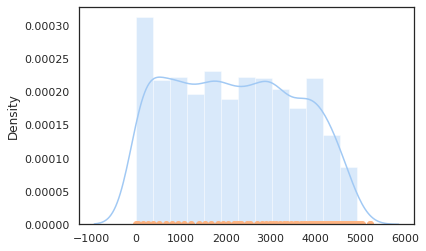

In [459]:
sns.distplot(train['t'][train['e']==1])
plt.plot(tt, np.zeros(len(tt)),'o')
len(tt)

### Embedding the covariates into $\mathbb{R}^m$
- for each continuous variable, first find $m$ landmarkers, then interpolate values in between
- for each categorical variable, find the matched embedding vector with $m$ dimensions

Define landmarkers for each continuous variable### Embedding the covariates into $\mathbb{R}^m$

In [460]:
from model.embedding import Embedding
from model.attention import Attention, SelfAttention
from model.ContrastiveLearning import FDV_CL
from model.SimpleNN import *


In [461]:
ncov = train['x'].shape[1]
covList = np.arange(ncov)

trainData = SimpleDataset_masked(train['x'], train['t'], train['e'], train['missing_mask'])
pair1 = DataLoader(trainData, batch_size=args.batch_size,shuffle=True, drop_last=True)

validData = SimpleDataset_masked(valid['x'], valid['t'], valid['e'], valid['missing_mask'])
v_pair1 = DataLoader(validData, batch_size=args.batch_size,shuffle=True, drop_last=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

testData = SimpleDataset_masked(test['x'], test['t'], test['e'], test['missing_mask'])
t_pair1 = DataLoader(testData, batch_size=args.batch_size,shuffle=True)


In [462]:
args.result_path_root

'/data/zidi/ACSurv/results/flchain'

In [513]:
class SelfAttention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """
    def __init__(self, dropout=0.1, alpha = 0.9):
        super(SelfAttention, self).__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout)
        self.alpha = alpha
    def forward(self, x, mask=None, flatten=True, aggregate=False, recompute=True):

        # scores = torch.matmul(query, key.transpose(-2, -1)) \
        #          / math.sqrt(query.size(-1))
        
        # f(query, key)
        # query: d \times m
        # (d x m ) x (m x d)
        # d \times d
        device = x.device
        if not aggregate:
            recompute = True
        if recompute:
            # recalculate attention score
            scores = torch.exp(torch.matmul(x, x.transpose(-2, -1))) \
                     / math.sqrt(x.size(-1))
            # mask missing points before softmax
            if type(mask) != type(None):
                mask_attn = attention_mask(mask.to(device), x.size(1))
            if aggregate:
                # Assume that the covariates dependencies are transferrable 
                p_attn = self.calculate_running_score(scores, mask_attn)
            else:
                if type(mask) != type(None):
                    scores = scores.masked_fill(mask_attn.to(device) == 0, 0)
                p_attn = F.softmax(scores, dim=-1)
                
            del scores, mask_attn

    #         if dropout is not None:
            p_attn = self.dropout(p_attn)
        
        else:
            # using stored scores
            scores = self.running_score.detach()
            p_attn = F.softmax(scores, dim=-1)
            p_attn = self.dropout(p_attn)
            
        if mask is not None:
            print(p_attn.size(), x.size(), mask.size())
            output = torch.matmul(p_attn, x*mask.unsqueeze(-1).to(device))
            del mask
        else:
            output = torch.matmul(p_attn, x)
        
        if flatten:
#             return self.flatten(output), p_attn
#             print(scores.size())
            return output.sum(1), p_attn.detach()
        else:
            return output, p_attn.detach()
        
    def calculate_running_score(self, scores, mask_attn=None):
#         print(scores.size())
        if type(mask_attn) != type(None):
            scores = scores.masked_fill(mask_attn.to(device) == 0, 0)
            scores_nonzero_mean = (scores.sum(0)/(mask_attn.sum(0)).to(scores.device))
            del mask_attn
        else:
            scores_nonzero_mean = scores.mean(0)
        
        if self.running_score is not None > 0:
            new_scores = (1-self.alpha)*self.running_score + self.alpha*scores_nonzero_mean
        else:
            new_scores = scores_nonzero_mean
        del scores, scores_nonzero_mean
                
        p_attn = (F.softmax(new_scores.repeat(len(x),1,1), dim=-1))
        self.running_score = torch.nn.Parameter(new_scores, requires_grad=False)
        return p_attn
        
 

In [514]:
zdim = args.s
epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = args.gpu
n_gpu = args.num_gpu
all_device = set(np.arange(args.num_gpu))
all_device.remove(args.gpu)
device_ids = [args.gpu] + list(all_device)

torch.cuda.set_device(device_name)

# point estimation loss function and weight
# loss_type = args.loss_type
# lambda_ = args.pt_wt
# ctr_wt = args.ct_wt
# bined time
tt = torch.tensor(tt).to(device)

result_path = args.result_path_root+'/saved_models/'
Path(result_path).mkdir(parents=True, exist_ok=True)

pickle.dump( args, open( result_path+args.store_name+"_args.pkl", "wb" ) )


'''covariate embedding'''
embedding = Embedding(ncov, cts_var, cts_idx, cat_var, cat_idx, x_landmarks, x_levels, m=args.s, dataset=train)
'''attention network'''
# attention = LinearAtt(ncov=ncov, dropout=0.1)
# attention = Attention(dropout=0.1)
attention = SelfAttention(dropout=0.1)
'''contrastive learning'''
# input is pair of latent Z
clf = FDV_CL(m = args.s, ncov = ncov, t_landmarks = t_landmarks, h_dim=args.enc_dim, trainable = True)


'''decoding the embedded vectors'''
decoder = DecMLP_bin(input_size = zdim, output_size = args.nbin, h_dim=args.dec_dim)

emb_path = result_path+args.store_name+'_emb'+'.pt'
dec_path = result_path+args.store_name+'_dec'+'.pt'
att_path = result_path+args.store_name+'_att'+'.pt'
# att_score_path = result_path+args.store_name+'_att_score'+'.pkl'

clf_path = result_path+args.store_name+'_clf'+'.pt'


if args.continue_training == 'True':
    embedding.load_state_dict(torch.load(emb_path))
    attention.load_state_dict(torch.load(att_path))
    clf.load_state_dict(torch.load(clf_path))
    decoder.load_state_dict(torch.load(dec_path))
    
# put models on device 0
embedding.to(device)
clf.to(device)
attention.to(device)
decoder.to(device)

# define optimizer
opt_emb = optim.Adam(embedding.parameters(), lr=args.emb_lr)
opt_dec = optim.Adam(decoder.parameters(), lr=args.dec_lr)
opt_clf = optim.Adam(clf.parameters(), lr=args.clf_lr)

# opt_emb = torch.optim.SGD(embedding.parameters(), args.emb_lr,
#                                 momentum=args.momentum,
#                                 weight_decay=args.weight_decay)

# opt_dec = torch.optim.SGD(decoder.parameters(), args.dec_lr,
#                                 momentum=args.momentum,
#                                 weight_decay=args.weight_decay)

# define scheduler
emb_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_emb, mode='min', factor=0.1, patience=5, min_lr=0, verbose=True)
dec_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_dec, mode='min', factor=0.1, patience=5, min_lr=0, verbose=True)
clf_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_clf, mode='min', factor=0.1, patience=5, min_lr=0, verbose=True)


decoder = nn.DataParallel(decoder, device_ids=device_ids)
attention = nn.DataParallel(attention, device_ids=device_ids)
clf = nn.DataParallel(clf, device_ids=device_ids)

# attention.running_score = attn_score

# att_path = result_path+model_name+'_att.pt'
print(embedding, attention, clf, decoder)

Embedding(
  (x_emb_landmarks): ParameterDict(
      (age): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (kappa): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (lambda): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
      (creatinine): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 1)]
  )
  (x_emb_levels): ParameterDict(
      (sex): Parameter containing: [torch.cuda.FloatTensor of size 2x16 (GPU 1)]
      (sample_yr): Parameter containing: [torch.cuda.FloatTensor of size 9x16 (GPU 1)]
      (flc_grp): Parameter containing: [torch.cuda.FloatTensor of size 10x16 (GPU 1)]
      (mgus): Parameter containing: [torch.cuda.FloatTensor of size 2x16 (GPU 1)]
  )
  (dropout): Dropout(p=0.0, inplace=False)
) DataParallel(
  (module): SelfAttention(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
) DataParallel(
  (module): FDV_CL(
    (criterion): 

torch.Size([128, 8, 8]) torch.Size([128, 8, 16]) torch.Size([128, 8])
torch.Size([128, 8, 8]) torch.Size([128, 8, 16]) torch.Size([128, 8])


<AxesSubplot:>

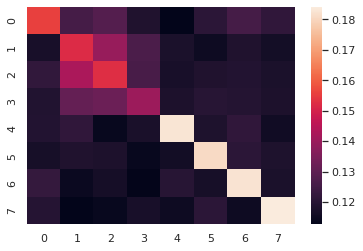

In [515]:
for i, (x, y, e, mask) in enumerate(pair1):
#         print(i)
    # training encoder and decoder

    x= x.to(device).float()
    y = y.to(device).float()
    e = e.to(device)

    x_emb, var_list = embedding(x)
#     prev_score = attention.running_score.cpu()
    # re-indexing mask
    # when certain observation is missed, the corresponding mask is 0
    reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list])
    mask_new = (torch.index_select(mask, 1, reindex))
#     mask_attn = attention_mask(mask_new, ncov) 
    z, attn_score = attention(x_emb, mask_new, aggregate=False)
#     updated_score = attention.running_score.cpu()
#     print(attn_score)
    break
    
sns.heatmap(attn_score.mean(0).cpu())


epoch1


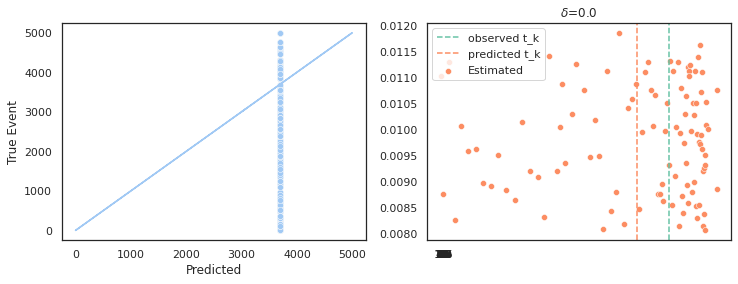

====> Train NLL: 1.833 	 Valid NLL: 1.939 CI: 0.606 event loss: 6.739 	 censoring loss : 0.109 	 Improved: *
epoch2
====> Train NLL: 1.829 	 Valid NLL: 1.963 CI: 0.637 event loss: 6.757 	 censoring loss : 0.107 	 Improved:  
epoch3
====> Train NLL: 1.826 	 Valid NLL: 1.962 CI: 0.658 event loss: 6.759 	 censoring loss : 0.107 	 Improved:  
epoch4
====> Train NLL: 1.825 	 Valid NLL: 1.957 CI: 0.662 event loss: 6.749 	 censoring loss : 0.107 	 Improved:  
epoch5


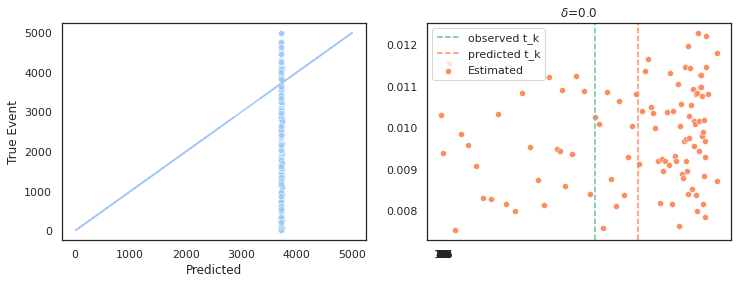

====> Train NLL: 1.822 	 Valid NLL: 1.938 CI: 0.668 event loss: 6.791 	 censoring loss : 0.106 	 Improved: *
epoch6


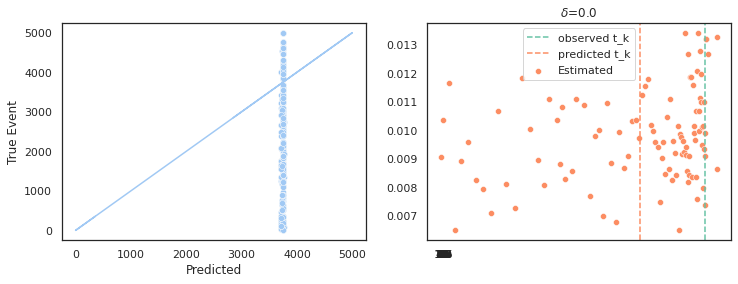

====> Train NLL: 1.814 	 Valid NLL: 1.916 CI: 0.672 event loss: 6.814 	 censoring loss : 0.103 	 Improved: *
epoch7


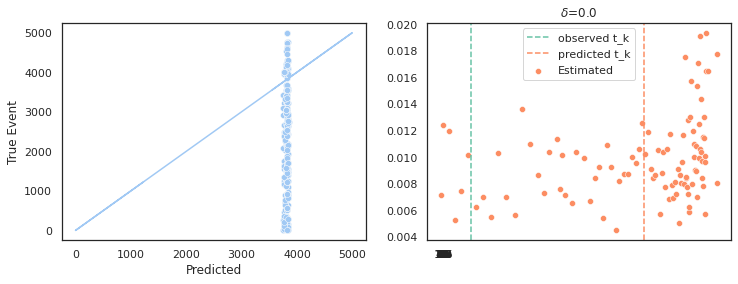

====> Train NLL: 1.798 	 Valid NLL: 1.894 CI: 0.676 event loss: 6.983 	 censoring loss : 0.094 	 Improved: *
epoch8


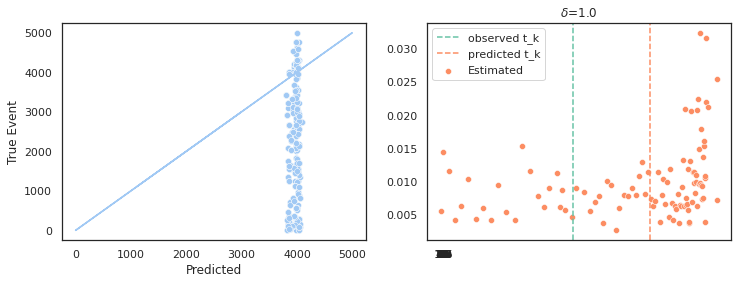

====> Train NLL: 1.756 	 Valid NLL: 1.770 CI: 0.689 event loss: 7.302 	 censoring loss : 0.074 	 Improved: *
epoch9


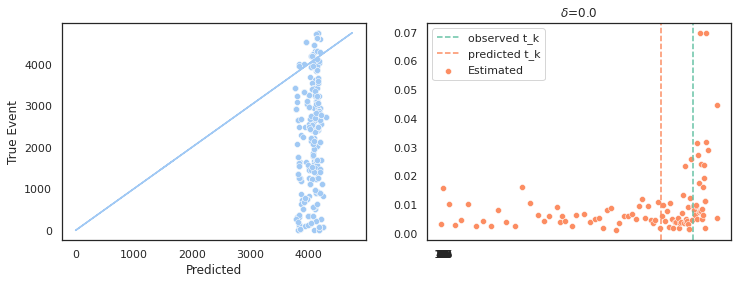

====> Train NLL: 1.708 	 Valid NLL: 1.722 CI: 0.718 event loss: 7.496 	 censoring loss : 0.057 	 Improved: *
epoch10


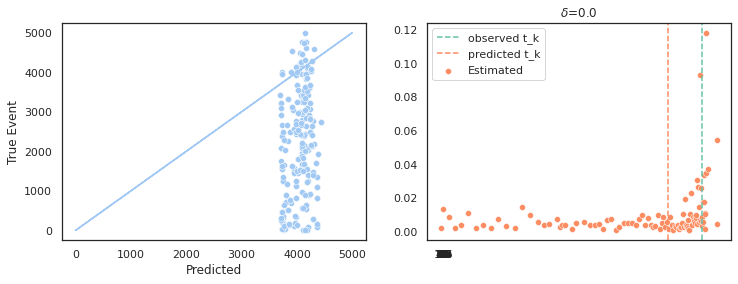

====> Train NLL: 1.665 	 Valid NLL: 1.660 CI: 0.730 event loss: 7.472 	 censoring loss : 0.051 	 Improved: *
epoch11


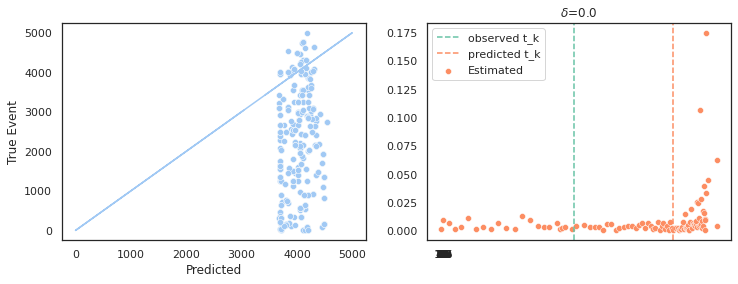

====> Train NLL: 1.638 	 Valid NLL: 1.602 CI: 0.747 event loss: 7.476 	 censoring loss : 0.048 	 Improved: *
epoch12
====> Train NLL: 1.620 	 Valid NLL: 1.608 CI: 0.745 event loss: 7.337 	 censoring loss : 0.046 	 Improved:  
epoch13


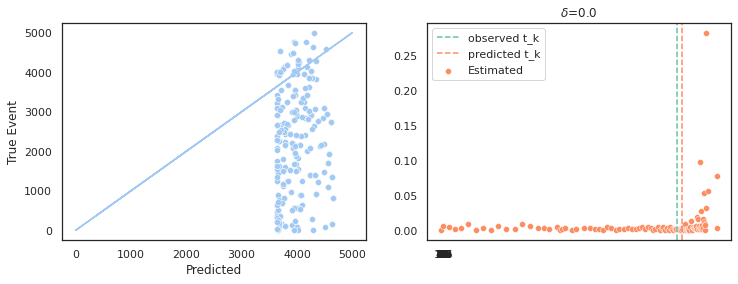

====> Train NLL: 1.596 	 Valid NLL: 1.579 CI: 0.752 event loss: 7.159 	 censoring loss : 0.046 	 Improved: *
epoch14


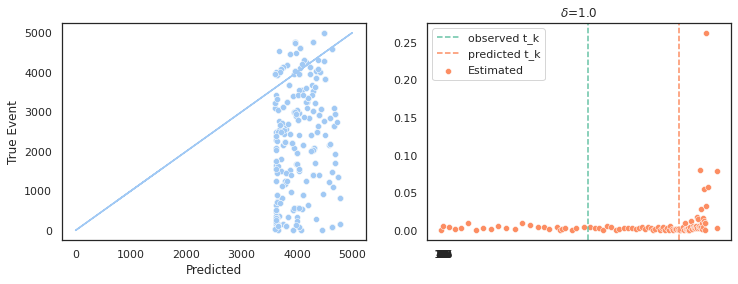

====> Train NLL: 1.582 	 Valid NLL: 1.570 CI: 0.764 event loss: 7.202 	 censoring loss : 0.038 	 Improved: *
epoch15


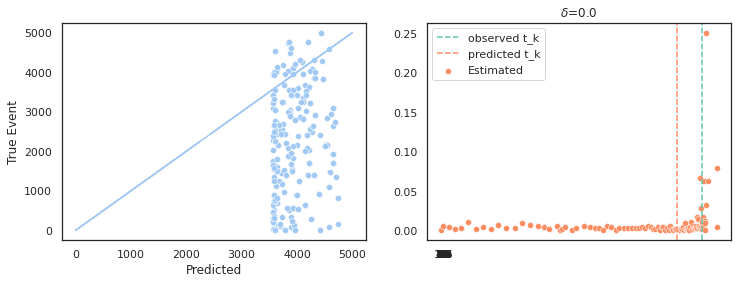

====> Train NLL: 1.568 	 Valid NLL: 1.562 CI: 0.764 event loss: 6.973 	 censoring loss : 0.044 	 Improved: *
epoch16


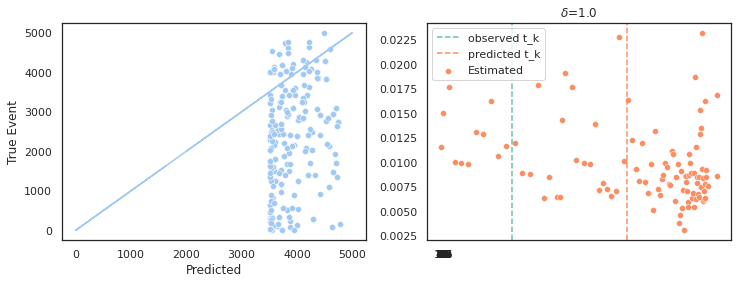

====> Train NLL: 1.553 	 Valid NLL: 1.561 CI: 0.769 event loss: 6.883 	 censoring loss : 0.043 	 Improved: *
epoch17


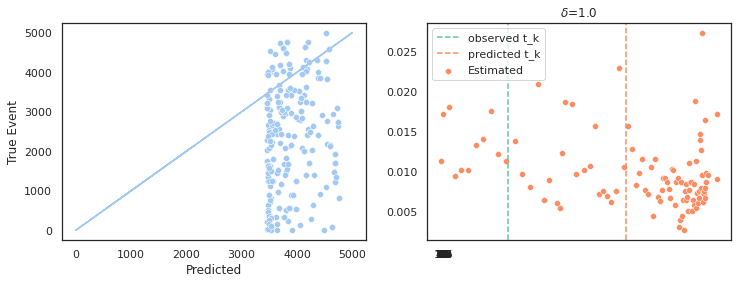

====> Train NLL: 1.546 	 Valid NLL: 1.550 CI: 0.777 event loss: 6.672 	 censoring loss : 0.043 	 Improved: *
epoch18


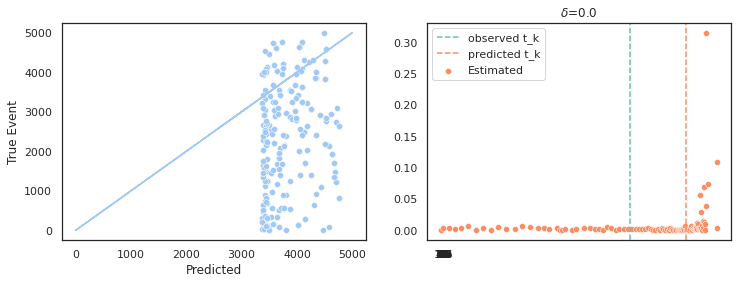

====> Train NLL: 1.531 	 Valid NLL: 1.549 CI: 0.772 event loss: 6.525 	 censoring loss : 0.049 	 Improved: *
epoch19


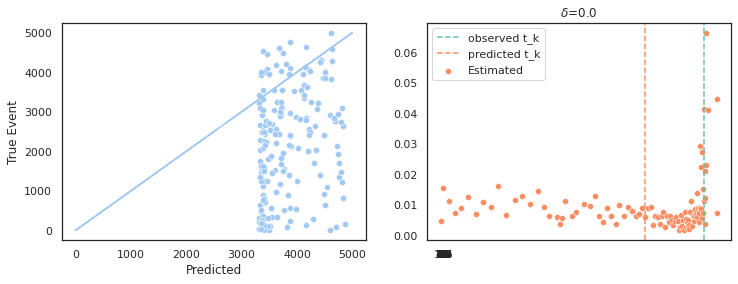

====> Train NLL: 1.520 	 Valid NLL: 1.524 CI: 0.778 event loss: 6.559 	 censoring loss : 0.039 	 Improved: *
epoch20


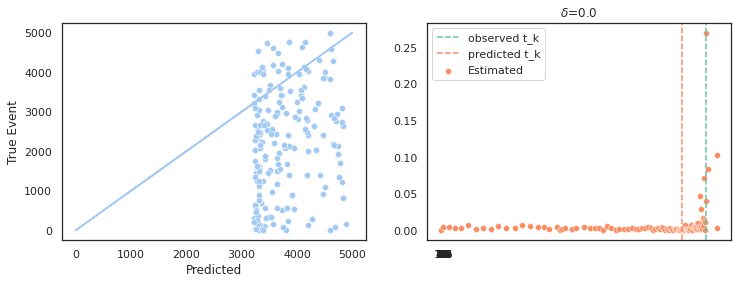

====> Train NLL: 1.515 	 Valid NLL: 1.518 CI: 0.776 event loss: 6.387 	 censoring loss : 0.041 	 Improved: *
epoch21


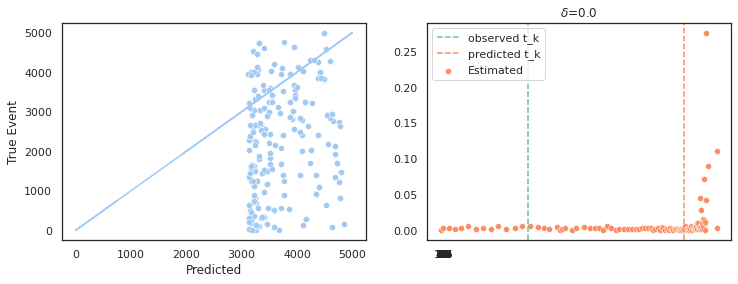

====> Train NLL: 1.508 	 Valid NLL: 1.539 CI: 0.780 event loss: 6.170 	 censoring loss : 0.049 	 Improved: *
epoch22


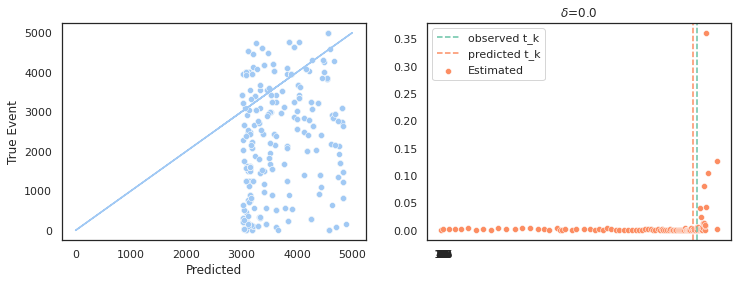

====> Train NLL: 1.495 	 Valid NLL: 1.522 CI: 0.778 event loss: 6.060 	 censoring loss : 0.044 	 Improved: *
epoch23


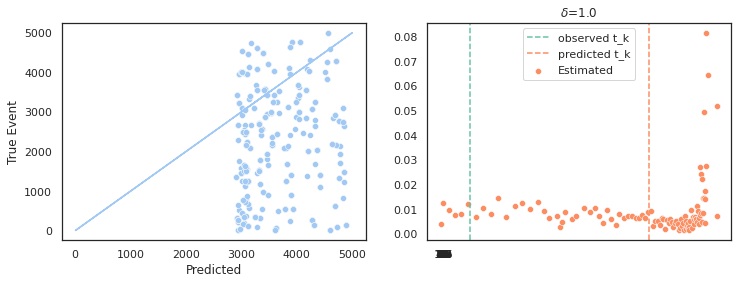

====> Train NLL: 1.491 	 Valid NLL: 1.488 CI: 0.779 event loss: 5.711 	 censoring loss : 0.044 	 Improved: *
epoch24
====> Train NLL: 1.489 	 Valid NLL: 1.499 CI: 0.777 event loss: 1.920 	 censoring loss : 0.046 	 Improved:  
epoch25


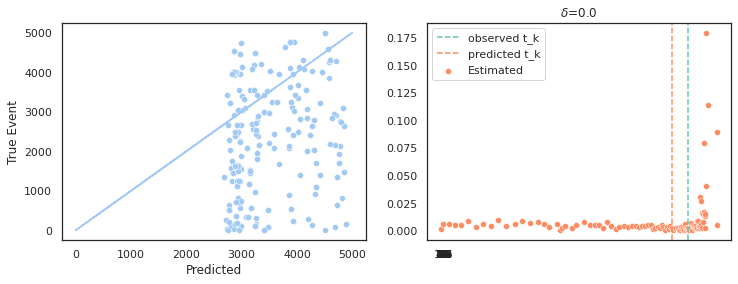

====> Train NLL: 1.479 	 Valid NLL: 1.491 CI: 0.785 event loss: 5.635 	 censoring loss : 0.047 	 Improved: *
epoch26
====> Train NLL: 1.470 	 Valid NLL: 1.496 CI: 0.780 event loss: 5.542 	 censoring loss : 0.045 	 Improved:  
epoch27
====> Train NLL: 1.467 	 Valid NLL: 1.503 CI: 0.779 event loss: 5.485 	 censoring loss : 0.043 	 Improved:  
epoch28


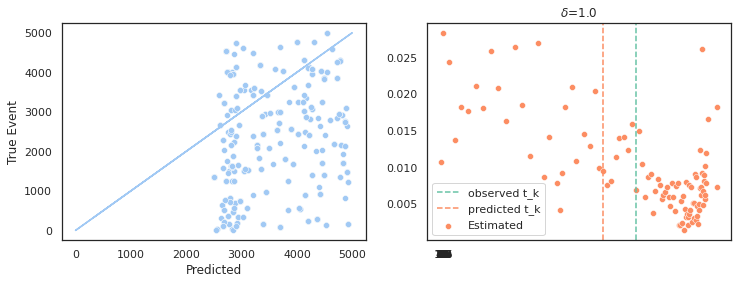

====> Train NLL: 1.461 	 Valid NLL: 1.477 CI: 0.773 event loss: 5.468 	 censoring loss : 0.040 	 Improved: *
epoch29
====> Train NLL: 1.459 	 Valid NLL: 1.491 CI: 0.770 event loss: 5.114 	 censoring loss : 0.047 	 Improved:  
epoch30


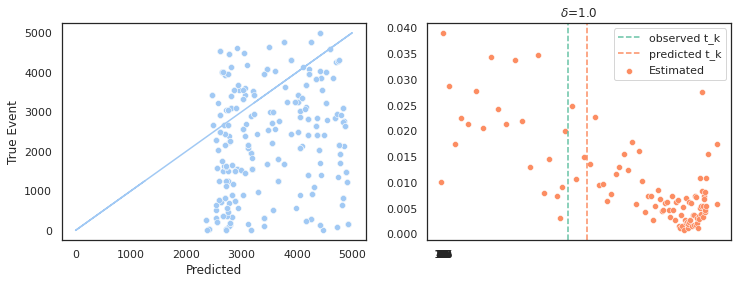

====> Train NLL: 1.455 	 Valid NLL: 1.506 CI: 0.777 event loss: 5.178 	 censoring loss : 0.045 	 Improved: *
epoch31


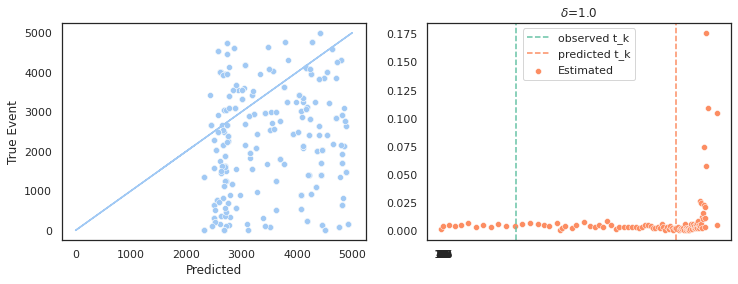

====> Train NLL: 1.450 	 Valid NLL: 1.470 CI: 0.777 event loss: 5.195 	 censoring loss : 0.046 	 Improved: *
epoch32


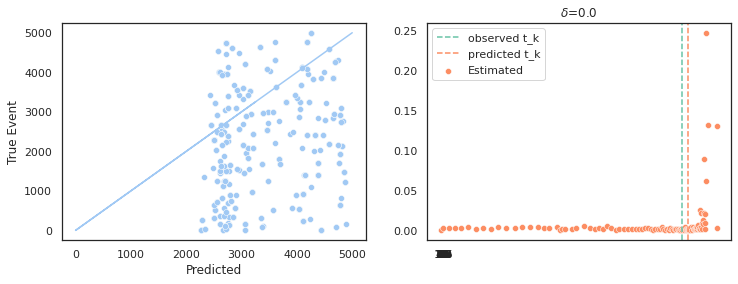

====> Train NLL: 1.443 	 Valid NLL: 1.499 CI: 0.782 event loss: 5.112 	 censoring loss : 0.051 	 Improved: *
epoch33


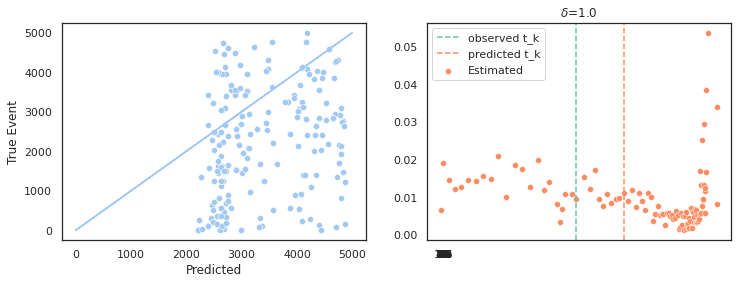

====> Train NLL: 1.438 	 Valid NLL: 1.493 CI: 0.775 event loss: 5.055 	 censoring loss : 0.052 	 Improved: *
epoch34
====> Train NLL: 1.441 	 Valid NLL: 1.498 CI: 0.775 event loss: 5.068 	 censoring loss : 0.049 	 Improved:  
epoch35
====> Train NLL: 1.439 	 Valid NLL: 1.498 CI: 0.774 event loss: 1.721 	 censoring loss : 0.049 	 Improved:  
epoch36
====> Train NLL: 1.437 	 Valid NLL: 1.528 CI: 0.773 event loss: 4.916 	 censoring loss : 0.056 	 Improved:  
epoch37
Epoch    37: reducing learning rate of group 0 to 1.0000e-05.
Epoch    37: reducing learning rate of group 0 to 1.0000e-05.
====> Train NLL: 1.439 	 Valid NLL: 1.535 CI: 0.770 event loss: 4.884 	 censoring loss : 0.060 	 Improved:  
epoch38
====> Train NLL: 1.432 	 Valid NLL: 1.515 CI: 0.771 event loss: 4.917 	 censoring loss : 0.055 	 Improved:  
epoch39
====> Train NLL: 1.432 	 Valid NLL: 1.518 CI: 0.773 event loss: 4.571 	 censoring loss : 0.055 	 Improved:  
epoch40
====> Train NLL: 1.428 	 Valid NLL: 1.521 CI: 0.771 event

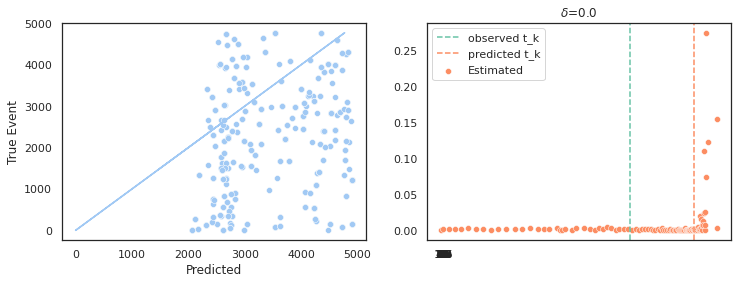

====> Train NLL: 1.429 	 Valid NLL: 1.499 CI: 0.780 event loss: 5.054 	 censoring loss : 0.046 	 Improved: *
epoch42
====> Train NLL: 1.429 	 Valid NLL: 1.513 CI: 0.773 event loss: 4.912 	 censoring loss : 0.051 	 Improved:  
epoch43
Epoch    43: reducing learning rate of group 0 to 1.0000e-06.
Epoch    43: reducing learning rate of group 0 to 1.0000e-06.
====> Train NLL: 1.425 	 Valid NLL: 1.513 CI: 0.772 event loss: 4.970 	 censoring loss : 0.048 	 Improved:  
epoch44
====> Train NLL: 1.430 	 Valid NLL: 1.540 CI: 0.778 event loss: 4.918 	 censoring loss : 0.056 	 Improved:  
epoch45
====> Train NLL: 1.424 	 Valid NLL: 1.533 CI: 0.771 event loss: 4.899 	 censoring loss : 0.054 	 Improved:  
epoch46
====> Train NLL: 1.435 	 Valid NLL: 1.516 CI: 0.776 event loss: 4.975 	 censoring loss : 0.050 	 Improved:  
epoch47
====> Train NLL: 1.433 	 Valid NLL: 1.542 CI: 0.772 event loss: 4.962 	 censoring loss : 0.055 	 Improved:  
epoch48
====> Train NLL: 1.426 	 Valid NLL: 1.534 CI: 0.775 event

In [490]:
best_valid_e_loss = np.inf
best_valid_NLL_loss = np.inf
best_valid_CI = 0
best_epoch = 0

train_loss_hist = []
train_loss_NLL_hist = []
train_loss_est_hist = []
train_lost_ctr_hist = []

valid_loss_hist = []
valid_loss_NLL_hist = []
valid_loss_est_hist = []
valid_lost_ctr_hist = []

for epoch in range(1, epochs + 1):


    train_loss = 0
    train_ctr_loss = 0
    train_NLL_loss, train_est_loss = 0, 0
    
    valid_e_loss = 0
    valid_c_loss = 0
    valid_NLL_loss, valid_est_loss = 0, 0

    print('epoch'+str(epoch))
    improved_str = " "
    embedding.train()
    clf.train()
    decoder.train()


    for i, (x, y, e, mask) in enumerate(pair1):
#         print(i)
        # training encoder and decoder
        
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
            
        x_emb, var_list = embedding(x)
        
        # re-indexing mask
        # when certain observation is missed, the corresponding mask is 0
        reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list])
        mask_new = (torch.index_select(mask, 1, reindex)).to('cpu')
        del mask
#         mask_attn = attention_mask(mask_new, ncov) 
#         del mask_new
        z, attn_score = attention(x_emb, mask_new, aggregate = args.attn_aggregate)
        del mask_new
        
        loss_infoNCE = clf(z, y, e).mean()
        
        p_raw = decoder(clf.module.enc(z))
        
        loss_NLL = NLL_reg_emb(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
        
        eloss, closs = point_loss(t_wa_hat, y, e, args.loss_type)
        loss_est = (closs + eloss)/len(e)
    
        surv_loss = loss_NLL + args.pt_wt*loss_est

        # update parameters
        loss = surv_loss + args.ct_wt*loss_infoNCE
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(embedding.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-1)
        
        train_loss += surv_loss.item()
        train_NLL_loss += loss_NLL.item()
        train_est_loss += loss_est.item()
        train_ctr_loss += loss_infoNCE.item()
        
        opt_emb.step()
        opt_clf.step()
        opt_dec.step()  
        

    
    embedding.eval()
    attention.eval()
    decoder.eval()
    clf.eval()
    
    valid_e_loss = 0
    valid_c_loss = 0
    valid_ct_loss = 0
    valid_pred_t, valid_e, valid_t = [],[],[]

    for i, (x, y, e, mask) in enumerate(v_pair1):
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        x_emb, var_list = embedding(x)
        
        # re-indexing mask
        reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list])
        mask_new = torch.index_select(mask, 1, reindex)
        del mask
#         mask_attn = attention_mask(mask_new, ncov) 
        
        z, attn_score = attention(x_emb, mask_new, aggregate = args.attn_aggregate, recompute=False)
        del mask_new
        
        loss_infoNCE = clf(z, y, e).mean()
        
        p_raw = decoder(clf.module.enc(z))
        
        loss_NLL = NLL_reg(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
#         t_wa_hat = get_median(p_raw, tt,0.5)
        
        # save one subject for plotting
        subj = np.random.choice(len(e))
        subj_res = t_wa_hat[subj].squeeze().detach().cpu().item(), p_raw[subj].detach().cpu().numpy(), y[subj].detach().cpu().item(), e[subj].detach().cpu().item()
        
        eloss, closs = point_loss(t_wa_hat, y, e, args.loss_type)
        loss_est = (closs + eloss)/len(e)
    
        loss = loss_NLL + args.pt_wt*loss_est

        valid_e_loss += eloss.item()
        
        valid_c_loss += closs.item()
        valid_ct_loss += loss_infoNCE.item()
        
        valid_NLL_loss += loss_NLL.item()
        valid_est_loss += loss_est.item()
        
        valid_pred_t.append(t_wa_hat.squeeze().detach().cpu().numpy())
        valid_t.append(y.squeeze().detach().cpu().numpy())
        valid_e.append(e.squeeze().detach().cpu().numpy())
        del t_wa_hat, y, e, loss, loss_NLL, loss_est, eloss, closs, loss_infoNCE
    
    # try scheduler
    emb_scheduler.step(valid_NLL_loss)
    clf_scheduler.step(valid_ct_loss)
    dec_scheduler.step(valid_NLL_loss)
        
    # concatenate all the validation results
    valid_e = np.concatenate(valid_e)
    valid_t = np.concatenate(valid_t)
    valid_pred_t = np.concatenate(valid_pred_t)

    valid_CI = get_CI_raw(valid_e, valid_t, valid_pred_t, torch_object=False)[0]
    
    train_loss_hist.append(train_loss/train_size)
    train_loss_NLL_hist.append(train_NLL_loss/train_size)
    train_loss_est_hist.append(train_est_loss/train_size)
    train_lost_ctr_hist.append(train_ctr_loss/train_size)
    
    valid_loss_hist.append(valid_e_loss/val_size)
    valid_loss_NLL_hist.append(valid_NLL_loss/val_size)
    valid_loss_est_hist.append(valid_est_loss/val_size)
    valid_lost_ctr_hist.append(valid_ct_loss/val_size)
    
    save_model = 0
    if (best_valid_e_loss > valid_e_loss):
        save_model += 1
    if (best_valid_NLL_loss > valid_NLL_loss):
        save_model += 2
    if (best_valid_CI < valid_CI):
        save_model += 1


    if save_model >1:
        best_epoch = epoch
        best_valid_e_loss = valid_e_loss
        best_valid_NLL_loss = valid_NLL_loss
        best_valid_CI = valid_CI
        
        torch.save(embedding.state_dict(), emb_path)
        torch.save(clf.module.state_dict(), clf_path)
        torch.save(decoder.module.state_dict(), dec_path)
        torch.save(attention.state_dict(), att_path)
        
#         torch.save(attention.module.state_dict(), att_path)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        r_idx = np.random.choice(np.where(valid_e==1)[0],500)
        sns.scatterplot(valid_pred_t[r_idx], valid_t[r_idx])
        plt.plot(valid_t[r_idx], valid_t[r_idx])
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
        
        
        
        plt.subplot(1, 2, 2)
        t_hat, p_raw, true_t, event_type = subj_res
        plt.axvline(true_t,linestyle='--',color=emp_color,label='observed t_k')
        plt.axvline(t_hat,linestyle='--',color=pred_color,label='predicted t_k')

        sns.scatterplot(tt.cpu().detach().numpy(), p_raw, label='Estimated', color=pred_color)
        plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

        plt.title(r'$\delta$='+str(event_type))
        plt.show()


        improved_str = "*"
    print('====> Train NLL: {:.3f} \t Valid NLL: {:.3f} CI: {:.3f} event loss: {:.3f} \t censoring loss : {:.3f} \t Improved: {}'.format(train_NLL_loss/train_size, valid_NLL_loss/val_size, valid_CI, valid_e_loss/val_size,valid_c_loss/val_size,improved_str))

    
#     if ctr_learning and (epoch - best_epoch >=20):
#         ctr_learning = False
#         print('Contrastive learning stopped')
    
#     if not ctr_learning and (epoch - best_epoch >=50):
#         print('Model stopped due to early stopping')
#         break
    del valid_t, valid_e, valid_pred_t
    if epoch - best_epoch >=20:
        print('Model stopped due to early stopping')
        break

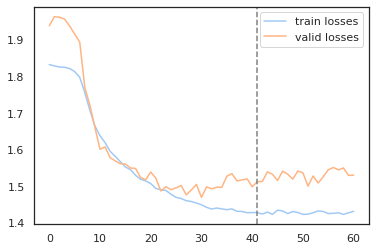

In [491]:
plt.plot(train_loss_NLL_hist,label="train losses")
plt.plot(valid_loss_NLL_hist,label="valid losses")
plt.axvline(best_epoch, color='gray',linestyle='--')
plt.legend()

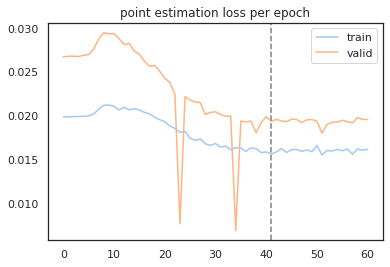

In [492]:
plt.plot(train_loss_est_hist,label="train")
plt.plot(valid_loss_est_hist,label="valid")
plt.axvline(best_epoch, color='gray',linestyle='--')

plt.title('point estimation loss per epoch')

plt.legend()

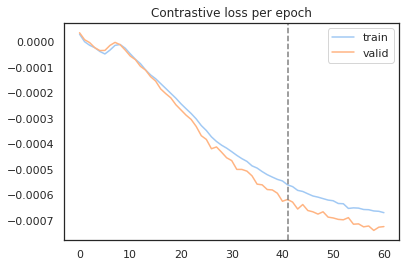

In [493]:
plt.plot(train_lost_ctr_hist,label="train")
plt.plot(valid_lost_ctr_hist,label="valid")
plt.axvline(best_epoch, color='gray',linestyle='--')

plt.title('Contrastive loss per epoch')

plt.legend()

In [495]:

'''covariate embedding'''
embedding = Embedding(ncov, cts_var, cts_idx, cat_var, cat_idx, x_landmarks, x_levels, m=args.s, dataset=train)

'''attention network'''
# attention = LinearAtt(ncov=ncov, dropout=0.1)
# attention = Attention(dropout=0.1)
attention = SelfAttention(dropout=0.1)
'''contrastive learning'''
# input is pair of latent Z
clf = FDV_CL(m = args.s, ncov = ncov, t_landmarks = t_landmarks, h_dim=args.enc_dim, trainable = True)


'''decoding the embedded vectors'''
decoder = DecMLP_bin(input_size = zdim, output_size = args.nbin, h_dim=args.dec_dim)


embedding.load_state_dict(torch.load(emb_path))
attention.load_state_dict(torch.load(att_path))
clf.load_state_dict(torch.load(clf_path))
decoder.load_state_dict(torch.load(dec_path))


# put models on device 0
embedding.to(device)
clf.to(device)
attention.to(device)
decoder.to(device)


decoder = nn.DataParallel(decoder, device_ids=device_ids)
attention = nn.DataParallel(attention, device_ids=device_ids)
clf = nn.DataParallel(clf, device_ids=device_ids)



In [496]:
# sns.heatmap(attention.running_score.cpu())


<AxesSubplot:>

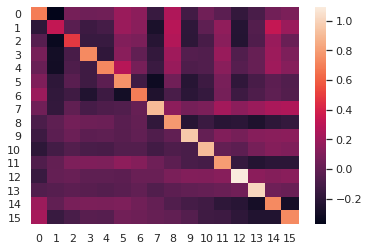

In [497]:
sns.heatmap(clf.module.time_emb_landmark.detach().cpu().numpy())
# clf.module.time_emb_landmark

Text(0.5, 1.0, 'AGE embedding')

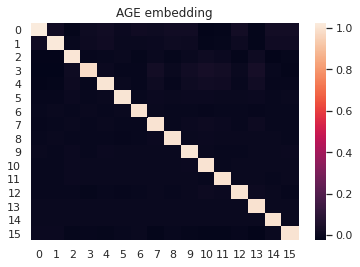

In [498]:
ax = sns.heatmap(embedding.x_emb_landmarks['kappa'].detach().cpu().numpy())
plt.title('AGE embedding')

### Evaluating performance on testing dataset

In [499]:
from utils.metrics import NLL_reg, point_loss, get_CI_raw, pair_Ctd_DLN


embedding.eval()
decoder.eval()
clf.eval()
attention.eval()


test_e_loss = test_c_loss= 0
test_pred_t = []
test_pred_med_t = []

test_pred_raw = []
test_t = []
test_e = []
# test_x = []
for i, (x, y, e, mask) in enumerate(t_pair1):
    x= x.to(device).float()
    y = y.to(device).float()
    e = e.to(device)
    
    x_emb, var_list = embedding(x.float())

    # re-indexing mask
    reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list])
    mask_new = torch.index_select(mask, 1, reindex)
    del mask
#     mask_attn = attention_mask(mask_new, ncov, p=0.1)
#     del mask_new

    z, attn_score = attention(x_emb, mask = mask_new, aggregate=args.attn_aggregate, recompute=False)
    del mask_new
 
    p_raw = decoder(clf.module.enc(z))

    loss_NLL = NLL_reg(p_raw, y, e, tt)

    # median
    t_wa_hat = wt_avg(p_raw, tt)
    t_med_hat = get_median(p_raw, tt, 0.5)

    eloss, closs = point_loss(t_wa_hat, y, e, args.loss_type)
    loss_est = closs + eloss

    loss = loss_NLL + args.pt_wt*loss_est
    
#     test_x.append(x)
    test_pred_raw.append(p_raw.detach().cpu())
    test_pred_t.append(t_wa_hat.squeeze().detach().cpu())
    test_pred_med_t.append(t_med_hat.squeeze().detach().cpu())
    test_t.append(y.squeeze().detach().cpu())
    test_e.append(e.squeeze().detach().cpu())
    test_e_loss += eloss.item()

    test_c_loss += closs.item()

print(test_e_loss/len(test['e']))


10.239457895461879


In [526]:
weights = p_raw# create a tensor of weights
rand_idx = torch.multinomial(weights, 1).squeeze()
tt[rand_idx]
rand_idx

tensor([ 98,  54,  48,  97,  98,   5,  96,  98,  98,  98,  98,  92,  89,  33,
        101,  13,   0,  98,  97], device='cuda:1')

In [527]:
len(rand_idx), len(tt[rand_idx])

(19, 19)

In [520]:
len(tt), p_raw.size()

(102, torch.Size([19, 102]))

Text(0.5, 1.0, 'Attention Score')

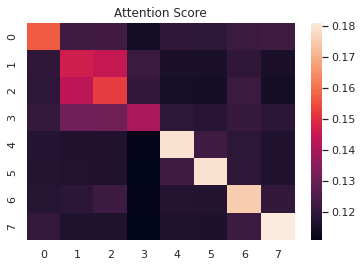

In [501]:
attn_score_avg = attn_score.mean(0)
ax = sns.heatmap(attn_score_avg.detach().cpu().numpy())
plt.xticks_l = list(cov_list)
plt.title('Attention Score')

In [502]:
def NLL_reg(p_raw, y, e, tt, collapsed=True):
    # using likelihood to regularize the performance
    y_cat = batch_t_categorize(y, e, tt)
    #         keep_idx = torch.where(y <= t_max)[0]
    
    if collapsed:
        y_loglikeli = -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-6).log().sum()
    else:
        y_loglikeli = -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-6).log()
    #  -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-4).log().mean()
    
    return y_loglikeli

tensor(1.7753)

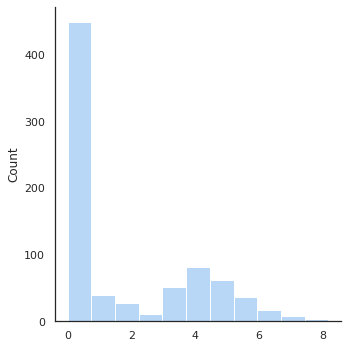

In [503]:
test_pred_raw = torch.cat(test_pred_raw)
test_e = torch.cat(test_e)
test_t = torch.cat(test_t)
test_pred_t = torch.cat(test_pred_t)
test_pred_med_t = torch.cat(test_pred_med_t)

# test_x = torch.cat(test_x)
test_likeli = NLL_reg(test_pred_raw, test_t, test_e, tt.cpu(), collapsed=False)
sns.displot(test_likeli.cpu().detach().numpy())
test_likeli.mean()


In [504]:
def I_Ctd_DLN(t, e, test_pred_prob, tt, i,j):
#     x_i = x[i]
#     x_j = x[j]
    t_true_i = t[i]
#     t_i_idx = torch.where(batch_t_categorize(t[i].reshape([1,1]), e[i].reshape([1,1]), tt)[-1]==1)[0]
    t_i_idx = torch.searchsorted(tt,t_true_i)
    sum_idx = torch.cat([torch.ones(t_i_idx), torch.zeros(len(tt)-t_i_idx)])
#     print(test_pred_prob[i], sum_idx)
    F_i = torch.dot(test_pred_prob[i].squeeze(), sum_idx)
    F_j = torch.dot(test_pred_prob[j].squeeze(), sum_idx)
    return(1*(F_i > F_j).cpu().detach().item())
    # return (log_S_i, log_S_j)

def pair_Ctd_DLN(t, e, test_pred_prob, tt):
    j_pool = []
    while len(j_pool)==0:
        subj_i = np.random.choice(torch.where(e==1)[0],1)
        j_pool = torch.where(t>t[subj_i])[0]
        
    subj_j = np.random.choice(torch.where(t>t[subj_i])[0],1)
        
    return(I_Ctd_DLN(t, e, test_pred_prob, tt, subj_i,subj_j))

In [505]:
ACSurv_Ctd = [pair_Ctd_DLN(test_t.to('cpu'), test_e.to('cpu'), test_pred_raw.to('cpu'), tt.to('cpu')) for k in np.arange(10000)]
np.mean(ACSurv_Ctd)

0.7621

0.7757088253004163

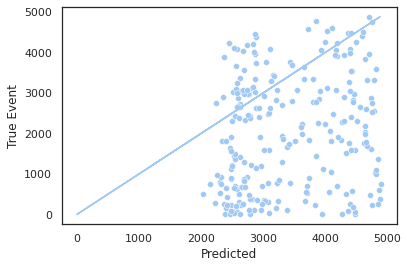

In [506]:

plt.figure()

sns.scatterplot(test_pred_t[test_e==1].cpu().detach().numpy().squeeze(), test_t[test_e==1].cpu())
plt.plot(test_t[test_e==1].cpu(), test_t[test_e==1].cpu())
plt.xlabel('Predicted')
plt.ylabel('True Event')

test_CI = get_CI_raw(test_e, test_t, test_pred_t, torch_object=True)[0]
test_CI


In [507]:
def calculate_quantiles(post_prob, tt, percentiles):
    post_prob_sum = np.cumsum(post_prob)
    try:
        tt_p = [tt[np.argmin(np.abs(post_prob_sum-p))] for p in percentiles]
    except TypeError:
        tt_p = tt[np.argmin(np.abs(post_prob_sum-percentiles))]
        tt_p = [tt_p]
        
    return(np.array(tt_p))


def calculate_coverage(pred_prob, tt, t_,quantiles, aft_model=False):
    if not aft_model:
        ci_list = [calculate_quantiles(post_prob,tt,quantiles) for post_prob in pred_prob]
        ci_list = np.array(ci_list)
    if aft_model:
        ci0 = aft.predict_percentile(pred_prob, p=quantiles[0]).values 
        ci1 = aft.predict_percentile(pred_prob, p=quantiles[1]).values
        ci_list = np.concatenate([ci1, ci0], axis=1)
        
    coverage_list = []
    for i in np.arange(len(t_)):
        if (t_[i]>=ci_list[i,0]) and (t_[i]<=ci_list[i,1]):
            coverage_list.append(1)            
        else:
            coverage_list.append(0)
    return(coverage_list)

def calculate_coverage_censor(pred_prob, tt, t_,quantiles, aft_model=False):
    if not aft_model:
        ci_list = [calculate_quantiles(post_prob,tt,quantiles) for post_prob in pred_prob]
        ci_list = np.array(ci_list)
    if aft_model:
        ci0 = aft.predict_percentile(pred_prob, p=quantiles).values 
        ci_list = np.array(ci0).reshape(len(t_))
    coverage_list = []
#     print(ci_list)
    for i in np.arange(len(t_)):
        if (t_[i]<=ci_list[i]):
            coverage_list.append(1)            
        else:
            coverage_list.append(0)
    return(coverage_list)


In [508]:
quantile_list = np.delete(np.linspace(0,0.5,10, endpoint=False),0)
quantiles_list = [[q, 1.-q]for q in quantile_list]
select_idx = (test_e.numpy()==1)
model_coverage =  [np.mean(calculate_coverage(test_pred_raw[select_idx].numpy(), tt.detach().cpu().numpy(), test_t[select_idx].numpy(),quantiles=q)) for q in quantiles_list]


In [509]:
model_coverage

[0.8685258964143426,
 0.6932270916334662,
 0.5776892430278885,
 0.4940239043824701,
 0.3745019920318725,
 0.30278884462151395,
 0.24302788844621515,
 0.1553784860557769,
 0.09163346613545817]

In [510]:
# load previous results
old_dir = '/data/zidi/cVAE/results/flchain'
def loadResults(session_name, out_dir):
    test_pred_prob = np.load(out_dir+'/{}_test_pred_prob'.format(session_name)+'.npy')
    test_loglikeli = np.load(out_dir+'/{}_test_loglikeli'.format(session_name)+'.npy')
    return  test_pred_prob, test_loglikeli
VSI_pred_prob, VSI_loglikeli= loadResults('cVAE_q_flchain', old_dir )
VSI_pred_medt = np.load(old_dir +'/{}_test_pred_medt'.format('cVAE_q_flchain')+'.npy')
VSI_pred_avgt = np.load(old_dir +'/{}_test_pred_avgt'.format('cVAE_q_flchain')+'.npy')
VSI_pred_randomt = np.load(old_dir +'/{}_test_pred_randomt'.format('cVAE_q_flchain')+'.npy')
VSI_tt = np.load(old_dir +'/{}_tt'.format('cVAE_q_flchain')+'.npy')


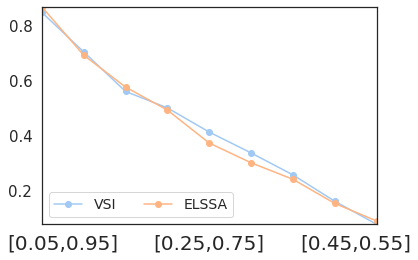

In [511]:
select_idx = test['e']==1
VSI_coverage =  [np.mean(calculate_coverage(VSI_pred_prob[select_idx], VSI_tt, test['t'][select_idx],quantiles=q)) for q in quantiles_list]
# RSF_coverage =  [np.mean(calculate_coverage(RSF_pred_prob[select_idx], tt, test['t'][select_idx],quantiles=q)) for q in quantiles_list]

sns.set_style("white")


plt.plot(VSI_coverage, '-o', label = 'VSI')
plt.plot(model_coverage, '-o', label = 'ELSSA')

# plt.plot(RSF_coverage, label = 'RSF', color = RSFcolor)
plt.margins(0,0)


plt.xticks([0.5,4,7.5],['[0.05,0.95]', '[0.25,0.75]', '[0.45,0.55]'],size=20, rotation=0)#, rotation=25)
plt.yticks([0.2,0.4,0.6,0.8],size=15)#, rotation=25)

plt.legend(prop={'size': 14},ncol=2,loc='lower left')

# plt.ylabel('coverage')
# plt.xlabel('quantiles range')
# plt.title('covarage rate for events\n'+'FLCHAIN Dataset')
# plt.savefig(fig_path+'/flchain_e_coverage.pdf', bbox_inches='tight')

([<matplotlib.axis.YTick at 0x7fc7cbb17940>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

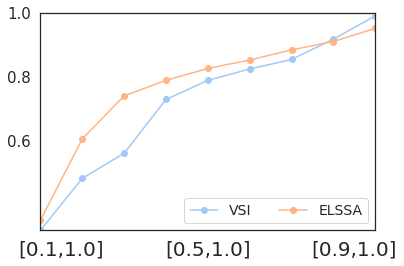

In [512]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

quantiles_list = np.delete(np.linspace(0,1.0,10, endpoint=False),0)

select_idx = (test['e']==0)
VSI_coverage =  [np.mean(calculate_coverage_censor(VSI_pred_prob[select_idx], VSI_tt, test['t'][select_idx],quantiles=q)) for q in quantiles_list]
# RSF_coverage =  [np.mean(calculate_coverage_censor(RSF_pred_prob[select_idx], tt, test['t'][select_idx],quantiles=q)) for q in quantiles_list]

select_idx = (test_e.numpy()==0)
model_coverage =  [np.mean(calculate_coverage_censor(test_pred_raw[select_idx].numpy(), tt.detach().cpu().numpy(), test_t[select_idx].numpy(),quantiles=q)) for q in quantiles_list]

sns.set_style("white")


plt.plot(VSI_coverage, '-o', label = 'VSI')
plt.plot(model_coverage, '-o', label = 'ELSSA')

range_list = [ "[" + str(np.round(q,2))+', 1.0]' for q in quantiles_list]

plt.margins(0,0)
plt.legend(prop={'size': 14},ncol=2,loc='lower right')

plt.xticks([0.5,4,7.5],['[0.1,1.0]', '[0.5,1.0]', '[0.9,1.0]'],size=20, rotation=0)#, rotation=25)
plt.yticks([0.6,0.8,1.0],size=15)#, rotation=25)

# plt.ylabel('coverage')
# plt.xlabel('quantiles range')
# plt.title('covarage rate for censoring\n'+'FLCHAIN Dataset')
# plt.savefig(fig_path+'/flchain_c_coverage.pdf', bbox_inches='tight')